<a href="https://colab.research.google.com/github/SatyaanikaPandam/Data-Science/blob/main/Unit_3_Project_The_Right_Likelihood_for_the_Job.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 3 Project: The Right Likelihood for the Job


My project investigates the number of Asian students admitted into the University of Texas from 1992 through 2024 to understand how the number has varied over time. Diversity in college admissions is a huge issue, and recently, discussions on whether or not some colleges are admitting too many Asian students without giving opportunities to other groups of minorities have escalated.


For example, Harvard's Class of 2024 saw a decline in the number of Black students, raising red flags on the scales of diversity in admissions. The freshman class of 2024 saw a 4% decrease in Black students, who made up 14% of the class. And here in Texas, things changed even further with the introduction of Senate Bill 17 going into effect in January of 2024. The law banned diversity offices and initiatives at public universities. So UT-Austin let go of around 60 employees this April in compliance with the law, and eliminated offices to help students from a variety of backgrounds.


Many students and faculty were incensed, protesting that the university was overstepping its authority and the new rules were poorly spelled out. My project is to determine how these changes, and with the general debate around diversity, may have impacted the admission of Asian students to UT over the years.

In [1]:
!pip install "preliz[full,notebook]"
import preliz as pz
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import pymc as pm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.9/509.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: nbclient
    Found existing installation: nbclient 0.10.0
    Uninstalling nbclient-0.10.0:
      Successfully uninstalled nbclient-0.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
osqp 0.6.7.post0 requires scipy!=1.12

In [2]:

url_admissions = 'https://raw.githubusercontent.com/SatyaanikaPandam/Data-Science/refs/heads/main/DATA%20-%20Sheet1%20(4).csv'
data_admissions = pd.read_csv(url_admissions)
data_admissions

,705
0,787
1,898
2,904
3,942
4,1130
5,1133
6,1221
7,1325
8,1413
9,1452


(array([4., 3., 8., 6., 1., 2., 2., 2., 2., 1.]),
 array([ 787. ,  973.3, 1159.6, 1345.9, 1532.2, 1718.5, 1904.8, 2091.1,
        2277.4, 2463.7, 2650. ]),
 <BarContainer object of 10 artists>)

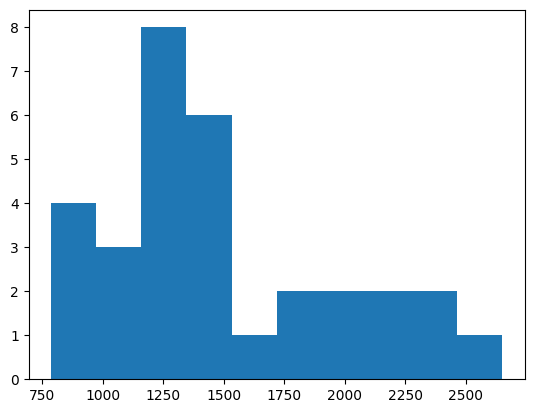

In [3]:
plt.hist(data_admissions)


The data is right-skewed (positively skewed).  Most of the data are clustered around lower values, with a few larger values stretching the distribution towards the right. The distribution is asymmetric, with a longer right tail.

<Axes: >

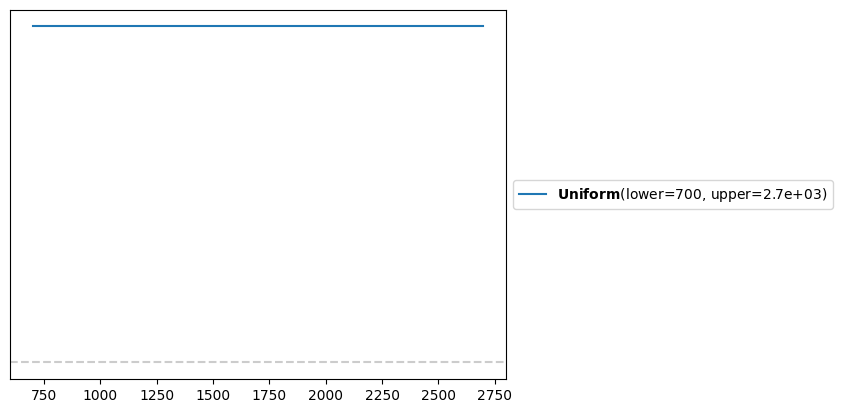

In [5]:
# 700 is a little lower than the smallest chemical shift,
# 2700 is a little higher than the largest chemical shift.
pz.Uniform(700,2700).plot_pdf()

# HalfNormal
I first used the Half-Normal Distribution because it only includes positive values, which is important when modeling things like a standard deviation that can’t be negative. It also keeps most of its weight near smaller numbers, so the model doesn’t try out extremely large values for variation. This is helpful because I expect smaller variations to be more realistic. The Half-Normal ensures that the model stays grounded in reasonable ranges unless the data says otherwise.

In [6]:
with pm.Model() as model_admissionsN:
    # Define a uniform prior for the mean
    μ = pm.Uniform('μ', lower=700, upper=2700)
    # Define a HalfNormal prior for the standard deviation, with a scale of 490
    σ = pm.HalfNormal('σ', sigma=490)
    # Define the likelihood (Y) as a normal distribution with μ and σ as parameters
    # 'observed' is the actual data used to fit the model
    Y = pm.Normal('Y', mu=μ, sigma=σ, observed=data_admissions)
    # Sample from the posterior distribution
    idata_admissionsN = pm.sample()


Output()

Output()

array([<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'σ'}>],
      dtype=object)

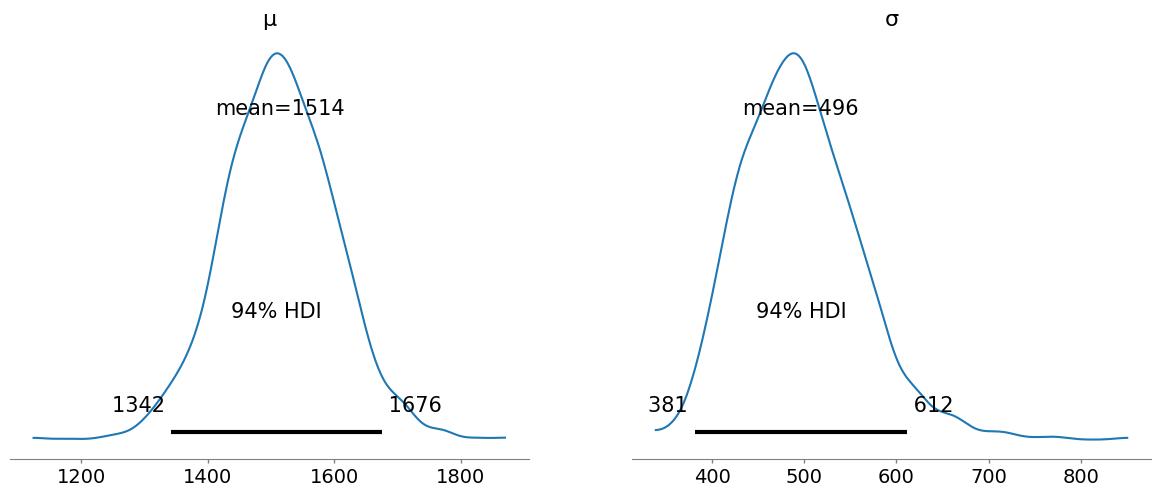

In [7]:
az.plot_posterior(idata_admissionsN)

Output()

<Axes: xlabel='Y'>

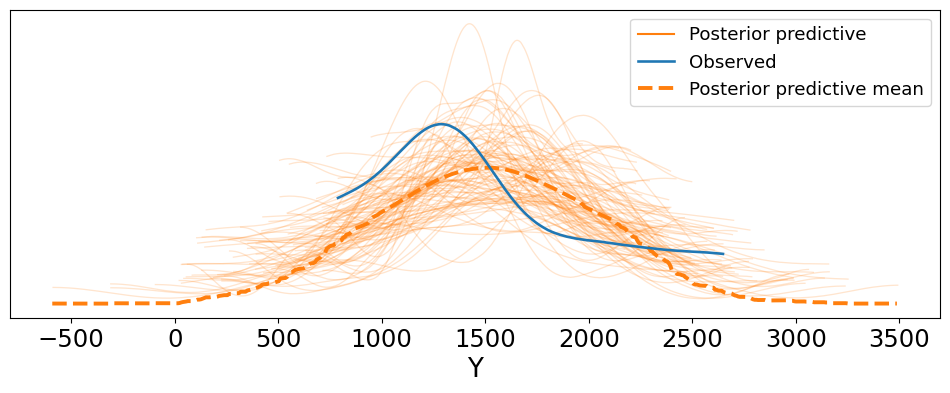

In [8]:
pm.sample_posterior_predictive(idata_admissionsN, model=model_admissionsN, extend_inferencedata=True)
pm.plot_ppc(idata_admissionsN, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

This didn't work correctly because the Half-Normal puts a lot of weight on smaller values, which might not give enough flexibility for my model to explore larger variations in the data. If the actual spread of my observed data is bigger than what the Half-Normal allows for, the model can underfit and fail to capture the real uncertainty. I used a Half-Normal for the standard deviation, but this might be too restrictive if my data has more variation. When checking the posterior predictive distribution, I saw that the model’s predictions didn’t match the data as closely as I expected,

# SkewNormal distribution

In [9]:
with pm.Model() as model_admissionsN:
    # a uniform prior between 700 and 2700
    μ = pm.Uniform('μ', lower=700, upper=2700)
    # a HalfNormal prior for the standard deviation - 490
    σ = pm.HalfNormal('σ', sigma=490)
    # Exponential prior for the skewness parameter (alpha) - 1/2
    alpha = pm.Exponential('alpha', lam=1/2)
    # Define the likelihood as a skew-normal distribution with μ, σ, and alpha
    y = pm.SkewNormal('y', mu=μ, sigma=σ, alpha=alpha, observed=data_admissions)
    # Sample from the posterior distribution
    idata_admissionsN = pm.sample()

Output()

Output()

In [ ]:
pm.sample_posterior_predictive(idata_admissionsN, model=model_admissionsN, extend_inferencedata=True)
az.plot_ppc(idata_admissionsN, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

I used the SkewNormal distribution for my model because my data is  skewed to the right. However, it didn't work well because the skewness parameter (α) might not have been flexible enough to match the true skew of my data.

# Inverse Gamma

In [10]:
import pymc as pm

with pm.Model() as model_admissionsG:
    # Assuming the mean is between the lowest and highest values recorded
    μ = pm.Uniform('μ', lower=700, upper=2700)

    # Alpha and Beta for the Inverse Gamma distribution
    alpha = pm.Exponential('alpha', lam=1)  # Shape parameter, must be positive
    beta = pm.Exponential('beta', lam=1)    # Scale parameter, must be positive

    # Inverse Gamma distribution for sigma (standard deviation)
    σ = pm.InverseGamma('σ', alpha=alpha, beta=beta)

    # Likelihood with new sigma prior (Inverse Gamma)
    Y = pm.Normal('Y', mu=μ, sigma=σ, observed=data_admissions)

    # Sampling the posterior
    idata_admissionsG = pm.sample()

Output()

Output()

Output()

<Axes: xlabel='Y'>

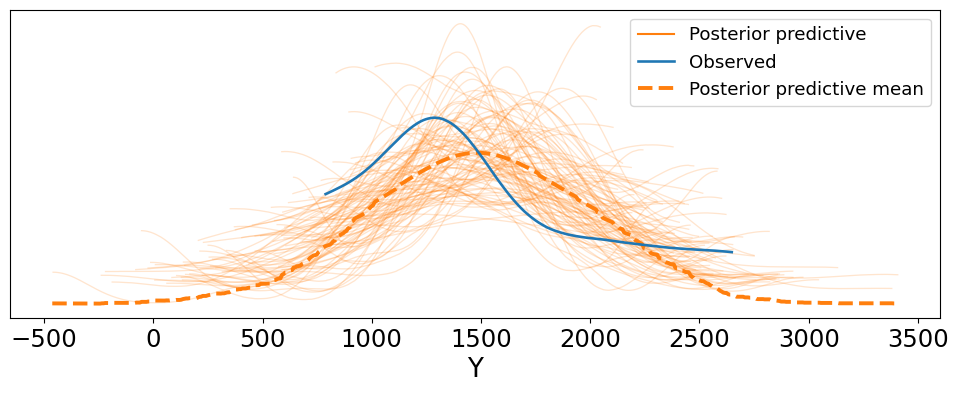

In [14]:
pm.sample_posterior_predictive(idata_admissionsG, model=model_admissionsG, extend_inferencedata=True)
az.plot_ppc(idata_admissionsG, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

# Uniform

In [15]:
import pymc as pm
import arviz as az
with pm.Model() as model_admissionsT:
    # weak prior
    μ = pm.Uniform('μ', lower=700, upper=2700)

    #the same as before
    σ = pm.HalfNormal('σ', sigma=416)

    #this is our normality parameter; lam = 1/30 gives a mean of 30
    ν = pm.Exponential('ν', lam = 1/30)

    #new likelihood, same data
    y = pm.StudentT('y', mu=μ, sigma=σ, nu = ν, observed=data_admissions)
    idata_admissionsT = pm.sample()

# Generate posterior predictive samples and add them to idata_admissionsT

pm.sample_posterior_predictive(idata_admissionsT, model=model_admissionsT, extend_inferencedata=True) #This line is crucial, it generates posterior predictive samples and adds them to idata_admissionsT


Output()

Output()

ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

(700.0, 2700.0)

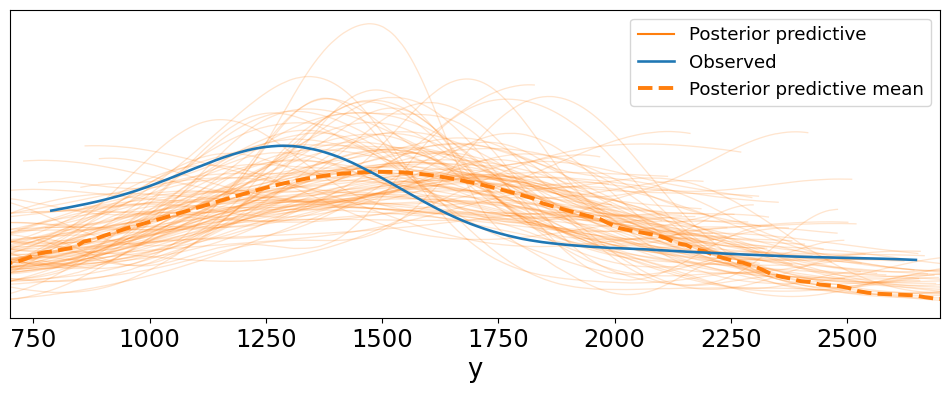

In [16]:
ax = az.plot_ppc(idata_admissionsT, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
ax.set_xlim(700,2700)

# Gamma

In [17]:
with pm.Model() as model_admissionsGamma:
    # prior
    μ = pm.Uniform('μ', lower=700, upper=2700)

    # Parameters for the Gamma distribution
    alpha = pm.Exponential('alpha', lam=1/1000)  # Shape parameter, must be positive
    beta = pm.Exponential('beta', lam=2000)    # Rate parameter, must also be positive

    # Gamma distribution likelihood
    Y = pm.Gamma('Y', alpha=alpha, beta=beta, observed=data_admissions)

    # Sample from the posterior
    idata_admissionsGamma = pm.sample()

Output()

Output()

Output()

<Axes: xlabel='y'>

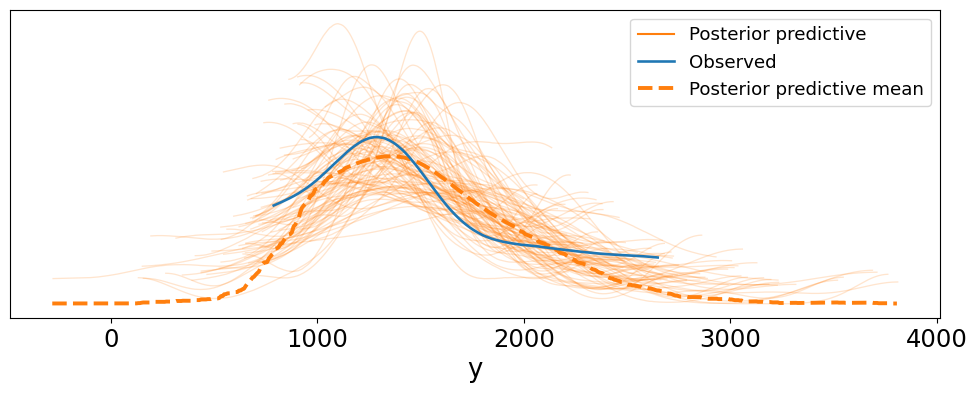

In [18]:
pm.sample_posterior_predictive(idata_admissionsN, model=model_admissionsN, extend_inferencedata=True)
az.plot_ppc(idata_admissionsN, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

# Conclusion
The Gamma distribution works the best for this dataset because it handles non-negative values, as all the numbers in my data (ranging from 705 to 2650) are positive. The dataset shows a right skew, meaning there are a few higher values that pull the average up, which is a situation where the Gamma distribution shines. This distribution is flexible in shape and can adjust to the varying spread of values in my dataset. The Gamma distribution captures a key characteristic of this data: as the numbers increase, the variability (or how spread out the values are) also tends to increase. I find that the Half-Normal distribution is designed for modeling non-negative values that follow a normal distribution on the positive side. However, it may not effectively capture the skewness in my dataset since it relies on a bell-shaped curve. My data is right-skewed, so i t has a long tail, which means the Gamma distribution is a better fit due to its flexibility in shape and ability to accurately model this skewness. The Uniform distribution operates on the assumption that all outcomes are equally likely within a defined range. This approach doesn't suit my data because it overlooks the varying frequencies of values and the specific trends present. My dataset has clear patterns that the Uniform distribution would fail to capture, whereas the Gamma distribution can adapt to these changing probabilities. The Skew-Normal distribution aims to model skewed data while maintaining some symmetry around the mean. Although it can address skewness, it might not reflect the unique behavior of my dataset as well as the Gamma distribution can. The Gamma distribution is good at modeling the right skew and the increasing variance I observe in my data.